# DTSA 5111 Week 5 GANs

Author: Alan Klein

Create Date: 2025-07-19

Github: https://github.com/Saganoky/dtsa-5511-gans

## Brief description of the problem and data

#### Description of problem
GANs are now able to create images that mimic a specific style.  The goal of this competition is to create a GAN and generate 7,000 to 10,000 images in the style of Monet a famous painter.

The competition will be judged using MiFID (Memorization-informed Fréchet Inception Distance).  More information on MiFID can be found on the Kaggel competition website.[1]

This code is based on the CycleGan tutorial by Amy Jang.[2]  As well as the cyclegan tensorflow tutorial.[3]

#### Data
The data consists of 300 images of painting by monet and 7038 photos.  These images are all tfrec files and are 256 x 256 x 3(rgb).

In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from kaggle_datasets import KaggleDatasets
import matplotlib.pyplot as plt
import numpy as np
import os

# GPU makes the most sense for this task as we have small batch sizes
strategy = tf.distribute.get_strategy() 

AUTOTUNE = tf.data.experimental.AUTOTUNE

print(strategy)

print(tf.__version__)

2.18.0


In [ ]:
# Code for Desktop
# import kaggle
# from kaggle.api.kaggle_api_extended import KaggleApi
# import os
# import matplotlib.pyplot as plt
# import numpy as np

# import tensorflow as tf
# from tensorflow import keras
# from tensorflow.keras import layers

# AUTOTUNE = tf.data.experimental.AUTOTUNE

In [ ]:
# This sets up the kaggle API.  You need to have a kaggle account and a token to be able to run this code.  
# This video gives a pretty good explanation of how to get the token: https://www.youtube.com/watch?v=gkEbaMgvLs8&t=188s
# api = KaggleApi()
# api.authenticate()

In [ ]:
# Run these two commands to download and unzip the data sets into the data folder.
# !kaggle competitions download -c gan-getting-started
# !unzip gan-getting-started.zip -d data/

In [ ]:
# Code for desktop
# We will use the tfrec files for the training.
# MONET_FILENAMES = [os.path.join('data/monet_tfrec', fname) for fname in os.listdir('data/monet_tfrec')]
# print('Monet TFRecord Files:', len(MONET_FILENAMES))

# PHOTO_FILENAMES = [os.path.join('data/photo_tfrec', fname) for fname in os.listdir('data/photo_tfrec')]
# print('Photo TFRecord Files:', len(PHOTO_FILENAMES))

In [4]:
GCS_PATH = "/kaggle/input/gan-getting-started"

MONET_FILENAMES = tf.io.gfile.glob(str(GCS_PATH + '/monet_tfrec/monet*.tfrec'))
PHOTO_FILENAMES = tf.io.gfile.glob(str(GCS_PATH + '/photo_tfrec/photo*.tfrec'))

print('Monet TFRecord Files:', len(MONET_FILENAMES))
print('Photo TFRecord Files:', len(PHOTO_FILENAMES))

Monet TFRecord Files: 5
Photo TFRecord Files: 20


In [5]:
# loads data from the tfrecord files
BUFFER_SIZE = 1000
BATCH_SIZE = 1
IMG_WIDTH = 256
IMG_HEIGHT = 256

# Adding jitter can help prevent overfitting per.[3]
def random_crop(image):
  cropped_image = tf.image.random_crop(
      image, size=[IMG_HEIGHT, IMG_WIDTH, 3])
  return cropped_image

def normalize(image):
  image = tf.cast(image, tf.float32)
  image = (image / 127.5) - 1
  return image

def random_jitter(image):
  # resizing to 286 x 286 x 3
  image = tf.image.resize(image, [286, 286],
                          method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  # randomly cropping to 256 x 256 x 3
  image = random_crop(image)
  # random mirroring
  image = tf.image.random_flip_left_right(image)
  return image

def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    # Add random jitter to the image.
    image = random_jitter(image)
    # This normalizes the pixel values to be between -1 and 1.
    image = normalize(image)
    return image

def read_tfrecord(example):
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    return image

def load_dataset(filenames, labeled=True, ordered=False):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTOTUNE)
    return dataset


monet_dataset = load_dataset(MONET_FILENAMES, labeled=True).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
photo_dataset = load_dataset(PHOTO_FILENAMES, labeled=True).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [6]:
# Explore the datasets
num_monet_images = sum(1 for _ in monet_dataset)
print(f"Number of images in the Monet dataset: {num_monet_images}")

num_photo_images = sum(1 for _ in photo_dataset)
print(f"Number of images in the Photo dataset: {num_photo_images}")


Number of images in the Monet dataset: 300
Number of images in the Photo dataset: 7038


## Exploratory Data Analysis (EDA) — Inspect, Visualize and Clean the Data (15 pts)
In the code above I loaded the dataset and added jitter to the images.  This should help with overfitting.  Below are some examples of the images.  You can run the code below multiple times to cycle though some of the images.  Note these are post jitter added.

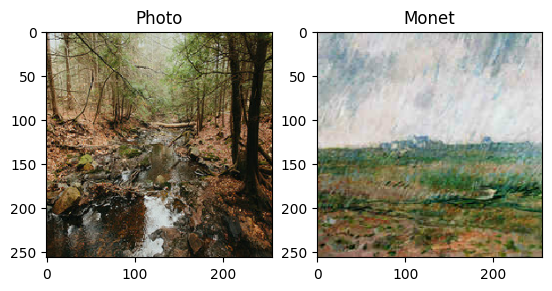

In [7]:
# Display some example images from the datasets
example_monet = next(iter(monet_dataset))
example_photo = next(iter(photo_dataset))

plt.subplot(121)
plt.title('Photo')
plt.imshow(example_photo[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Monet')
plt.imshow(example_monet[0] * 0.5 + 0.5)

## Model Architecture
This assignment is going to test 2 model architectures.  They are both cycle gan models, but one will use a unet generator and one will use a resnet generator.

For both the architectures we have:
discriminator with 3 convolution layers with a stride of 2 followed by 2 convolution layers.  They all use relu activations.

We will use Adam as the optimizer.  

The Unet generator consists of 8 convultion layers that downsample with a stride of 2 and 7 convolution transposes that upsample.  Followed by a conv layer that has a tanh activation.

The resnet generat consists of 2 convolution layers that downsample with a stride of 2 and then 18 convolution layers, followed by 2 more that upsample. With a final convolution layer that has a tanh activation.

In [9]:
# Set to 3 because the images are RGB.
OUTPUT_CHANNELS = 3

# Below defines the downsample and upsample functions used in the generator and discriminator models.
# These are modfied version from the CycleGAN tutorial by Amy Jang and the cyclegan tensorflow tutorial.[2][3]
# Note that instance normalization has been depreciated in TensorFlow 2.12 and replaced with GroupNormalization.
def downsample(filters, size, apply_instancenorm=True):
    # This is basically a combination of a convolutional layer and a normalization layer, 
    # with a LeakyReLU activation.  Will make the generator and discriminator code easier to read.
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = keras.Sequential()
    result.add(layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

    if apply_instancenorm:
        result.add(tf.keras.layers.GroupNormalization(groups=-1, gamma_initializer=gamma_init))

    result.add(layers.LeakyReLU())

    return result

def upsample(filters, size, apply_dropout=False):
    # upsample is a transposed convolution layer that upsamples the input image.
    # it consists of a transposed inverse convolutional layer, a normalization layer, a dropout layer and a ReLU activation.
    # Randomly initialized the weights of the normalization layer.
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = keras.Sequential()
    result.add(layers.Conv2DTranspose(filters, size, strides=2,
                                      padding='same',
                                      kernel_initializer=initializer,
                                      use_bias=False))

    result.add(tf.keras.layers.GroupNormalization(groups=-1, gamma_initializer=gamma_init))

    if apply_dropout:
        result.add(layers.Dropout(0.5))

    result.add(layers.ReLU())

    return result

def unet_generator():
    # Consists of 8 downsample layers followed by 7 upsample layers. And a final transposed convolution layer with tanh activation to produce the output image.
    inputs = layers.Input(shape=[256,256,3])

    # bs = batch size
    down_stack = [
        downsample(64, 4, apply_instancenorm=False), # (bs, 128, 128, 64)
        downsample(128, 4), # (bs, 64, 64, 128)
        downsample(256, 4), # (bs, 32, 32, 256)
        downsample(512, 4), # (bs, 16, 16, 512)
        downsample(512, 4), # (bs, 8, 8, 512)
        downsample(512, 4), # (bs, 4, 4, 512)
        downsample(512, 4), # (bs, 2, 2, 512)
        downsample(512, 4), # (bs, 1, 1, 512)
    ]

    up_stack = [
        upsample(512, 4, apply_dropout=True), # (bs, 2, 2, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 4, 4, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 8, 8, 1024)
        upsample(512, 4), # (bs, 16, 16, 1024)
        upsample(256, 4), # (bs, 32, 32, 512)
        upsample(128, 4), # (bs, 64, 64, 256)
        upsample(64, 4), # (bs, 128, 128, 128)
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                  strides=2,
                                  padding='same',
                                  kernel_initializer=initializer,
                                  activation='tanh') # (bs, 256, 256, 3)

    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = layers.Concatenate()([x, skip])

    x = last(x)

    return keras.Model(inputs=inputs, outputs=x)

def discriminator():
    # Consists of 3 downsample layers followed 2 convultion layers.
    initializer = tf.random_normal_initializer(0., 0.02)
    # Randomly initialized the weights of the normalization layer.
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    inp = layers.Input(shape=[256, 256, 3], name='input_image')

    x = inp

    down1 = downsample(64, 4, False)(x) # (bs, 128, 128, 64)
    down2 = downsample(128, 4)(down1) # (bs, 64, 64, 128)
    down3 = downsample(256, 4)(down2) # (bs, 32, 32, 256)

    zero_pad1 = layers.ZeroPadding2D()(down3) # (bs, 34, 34, 256)
    conv = layers.Conv2D(512, 4, strides=1,
                         kernel_initializer=initializer,
                         use_bias=False)(zero_pad1) # (bs, 31, 31, 512)

    norm1 = tf.keras.layers.GroupNormalization(groups=-1, gamma_initializer=gamma_init)(conv)

    leaky_relu = layers.LeakyReLU()(norm1)

    zero_pad2 = layers.ZeroPadding2D()(leaky_relu) # (bs, 33, 33, 512)

    last = layers.Conv2D(1, 4, strides=1,
                         kernel_initializer=initializer)(zero_pad2) # (bs, 30, 30, 1)

    return tf.keras.Model(inputs=inp, outputs=last)

In [10]:
with strategy.scope():
    monet_generator = unet_generator() # transforms photos to Monet-esque paintings
    photo_generator = unet_generator() # transforms Monet paintings to be more like photos
    
    monet_discriminator = discriminator() # differentiates real Monet paintings and generated Monet paintings
    photo_discriminator = discriminator() # differentiates real photos and generated photos

print("Monet Generator Summary:")
print(monet_generator.summary())

# print("Photo Generator Summary:")
# print(photo_generator.summary())

print("Monet Discriminator Summary:")
print(monet_discriminator.summary())

# print("Photo Discriminator Summary:")
# print(photo_discriminator.summary())

Monet Generator Summary:


Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 128, 128,  │      3,072 │ input_layer[0][0] │
│ (Sequential)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_1        │ (None, 64, 64,    │    131,328 │ sequential[0][0]  │
│ (Sequential)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_2        │ (None, 32, 32,    │    524,800 │ sequential_1[0][… │
│ (Sequential)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_3        │ (None, 16, 16,    │  2,098,176 │ sequential_2[0][… │
│ (Sequential)        │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_4        │ (None, 8, 8, 512) │  4,195,328 │ sequential_3[0][… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_5        │ (None, 4, 4, 512) │  4,195,328 │ sequential_4[0][… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_6        │ (None, 2, 2, 512) │  4,195,328 │ sequential_5[0][… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_7        │ (None, 1, 1, 512) │  4,195,328 │ sequential_6[0][… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_8        │ (None, 2, 2, 512) │  4,195,328 │ sequential_7[0][… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 2, 2,      │          0 │ sequential_8[0][… │
│ (Concatenate)       │ 1024)             │            │ sequential_6[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_9        │ (None, 4, 4, 512) │  8,389,632 │ concatenate[0][0] │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 4, 4,      │          0 │ sequential_9[0][… │
│ (Concatenate)       │ 1024)             │            │ sequential_5[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_10       │ (None, 8, 8, 512) │  8,389,632 │ concatenate_1[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 8, 8,      │          0 │ sequential_10[0]… │
│ (Concatenate)       │ 1024)             │            │ sequential_4[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_11       │ (None, 16, 16,    │  8,389,632 │ concatenate_2[0]… │
│ (Sequential)        │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 16, 16,    │          0 │ sequential_11[0]

 Total params: 54,414,979 (207.58 MB)

 Trainable params: 54,414,979 (207.58 MB)

 Non-trainable params: 0 (0.00 B)

None
Monet Discriminator Summary:


Model: "functional_35"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)        │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_30 (Sequential)      │ (None, 128, 128, 64)   │         3,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_31 (Sequential)      │ (None, 64, 64, 128)    │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_32 (Sequential)      │ (None, 32, 32, 256)    │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ zero_padding2d (ZeroPadding2D)  │ (None, 34, 34, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 31, 31, 512)    │     2,097,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ group_normalization_30          │ (None, 31, 31, 512)    │         1,024 │
│ (GroupNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_19 (LeakyReLU)      │ (None, 31, 31, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ zero_padding2d_1                │ (None, 33, 33, 512)    │             0 │
│ (ZeroPadding2D)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 30, 30, 1)      │         8,193 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,765,569 (10.55 MB)

 Trainable params: 2,765,569 (10.55 MB)

 Non-trainable params: 0 (0.00 B)

None


In [11]:
class CycleGan(keras.Model):
    def __init__(
        self,
        monet_generator,
        photo_generator,
        monet_discriminator,
        photo_discriminator,
        lambda_cycle=10,
    ):
        super(CycleGan, self).__init__()
        self.m_gen = monet_generator
        self.p_gen = photo_generator
        self.m_disc = monet_discriminator
        self.p_disc = photo_discriminator
        self.lambda_cycle = lambda_cycle
        
    def compile(
        self,
        m_gen_optimizer,
        p_gen_optimizer,
        m_disc_optimizer,
        p_disc_optimizer,
        gen_loss_fn,
        disc_loss_fn,
        cycle_loss_fn,
        identity_loss_fn
    ):
        super(CycleGan, self).compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn
        
    def train_step(self, batch_data):
        real_monet, real_photo = batch_data
        
        with tf.GradientTape(persistent=True) as tape:
            # photo to monet back to photo
            fake_monet = self.m_gen(real_photo, training=True)
            cycled_photo = self.p_gen(fake_monet, training=True)

            # monet to photo back to monet
            fake_photo = self.p_gen(real_monet, training=True)
            cycled_monet = self.m_gen(fake_photo, training=True)

            # generating itself
            same_monet = self.m_gen(real_monet, training=True)
            same_photo = self.p_gen(real_photo, training=True)

            # discriminator used to check, inputing real images
            disc_real_monet = self.m_disc(real_monet, training=True)
            disc_real_photo = self.p_disc(real_photo, training=True)

            # discriminator used to check, inputing fake images
            disc_fake_monet = self.m_disc(fake_monet, training=True)
            disc_fake_photo = self.p_disc(fake_photo, training=True)

            # evaluates generator loss
            monet_gen_loss = self.gen_loss_fn(disc_fake_monet)
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)

            # evaluates total cycle consistency loss
            total_cycle_loss = self.cycle_loss_fn(real_monet, cycled_monet, self.lambda_cycle) + self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)

            # evaluates total generator loss
            total_monet_gen_loss = monet_gen_loss + total_cycle_loss + self.identity_loss_fn(real_monet, same_monet, self.lambda_cycle)
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)

            # evaluates discriminator loss
            monet_disc_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)

        # Calculate the gradients for generator and discriminator
        monet_generator_gradients = tape.gradient(total_monet_gen_loss,
                                                  self.m_gen.trainable_variables)
        photo_generator_gradients = tape.gradient(total_photo_gen_loss,
                                                  self.p_gen.trainable_variables)

        monet_discriminator_gradients = tape.gradient(monet_disc_loss,
                                                      self.m_disc.trainable_variables)
        photo_discriminator_gradients = tape.gradient(photo_disc_loss,
                                                      self.p_disc.trainable_variables)

        # Apply the gradients to the optimizer
        self.m_gen_optimizer.apply_gradients(zip(monet_generator_gradients,
                                                 self.m_gen.trainable_variables))

        self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients,
                                                 self.p_gen.trainable_variables))

        self.m_disc_optimizer.apply_gradients(zip(monet_discriminator_gradients,
                                                  self.m_disc.trainable_variables))

        self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients,
                                                  self.p_disc.trainable_variables))
        
        return {
            "monet_gen_loss": total_monet_gen_loss,
            "photo_gen_loss": total_photo_gen_loss,
            "monet_disc_loss": monet_disc_loss,
            "photo_disc_loss": photo_disc_loss
        }

In [12]:
# Define the loss functions for the CycleGAN model.


with strategy.scope():
    loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    def discriminator_loss(real, generated):
      real_loss = loss_obj(tf.ones_like(real), real)
      generated_loss = loss_obj(tf.zeros_like(generated), generated)
      total_disc_loss = real_loss + generated_loss
      return total_disc_loss * 0.5
        
with strategy.scope():
    def generator_loss(generated):
      return loss_obj(tf.ones_like(generated), generated)

with strategy.scope():
    def calc_cycle_loss(real_image, cycled_image, LAMBDA):
      loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))
      return LAMBDA * loss1
        
with strategy.scope():
    def identity_loss(real_image, same_image, LAMBDA):
      loss = tf.reduce_mean(tf.abs(real_image - same_image))
      return LAMBDA * 0.5 * loss

In [13]:
with strategy.scope():
    # set the optimizers to use Adam with a learning rate of 2e-4 and beta_1 of 0.5.
    monet_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    
    monet_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)


In [14]:
with strategy.scope():
    cycle_gan_model = CycleGan(
        monet_generator, photo_generator, monet_discriminator, photo_discriminator
    )
    
    cycle_gan_model.compile(
        m_gen_optimizer = monet_generator_optimizer,
        p_gen_optimizer = photo_generator_optimizer,
        m_disc_optimizer = monet_discriminator_optimizer,
        p_disc_optimizer = photo_discriminator_optimizer,
        gen_loss_fn = generator_loss,
        disc_loss_fn = discriminator_loss,
        cycle_loss_fn = calc_cycle_loss,
        identity_loss_fn = identity_loss
    )

In [15]:
# Train the model
EPOCHS = 2

cycle_gan_history = cycle_gan_model.fit(
    tf.data.Dataset.zip((monet_dataset, photo_dataset)),
    epochs=EPOCHS,
    steps_per_epoch=300
)

Epoch 1/2


I0000 00:00:1753058991.419609     145 service.cc:148] XLA service 0x782228004a00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1753058991.420627     145 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1753058999.308773     145 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1753059028.008956     145 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


300/300 ━━━━━━━━━━━━━━━━━━━━ 152s 151ms/step - monet_disc_loss: 0.6343 - monet_gen_loss: 5.2705 - photo_disc_loss: 0.5863 - photo_gen_loss: 5.4952
Epoch 2/2


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


300/300 ━━━━━━━━━━━━━━━━━━━━ 47s 150ms/step - monet_disc_loss: 0.6848 - monet_gen_loss: 3.5354 - photo_disc_loss: 0.6337 - photo_gen_loss: 3.6925


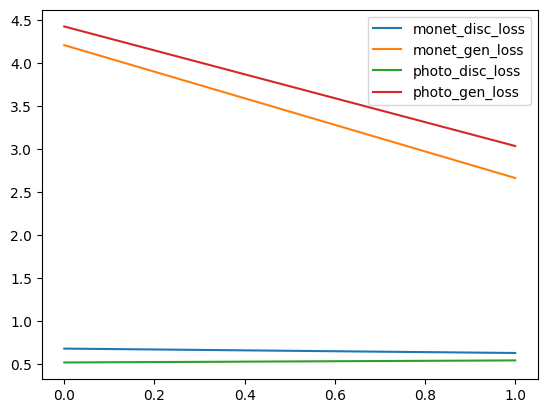

In [16]:
# Plot the training losses per epoch
history_keys = cycle_gan_history.history.keys()

for key in history_keys:
    cghk = cycle_gan_history.history[key]
    plt.plot(cghk, label=key)
plt.legend()
plt.show()


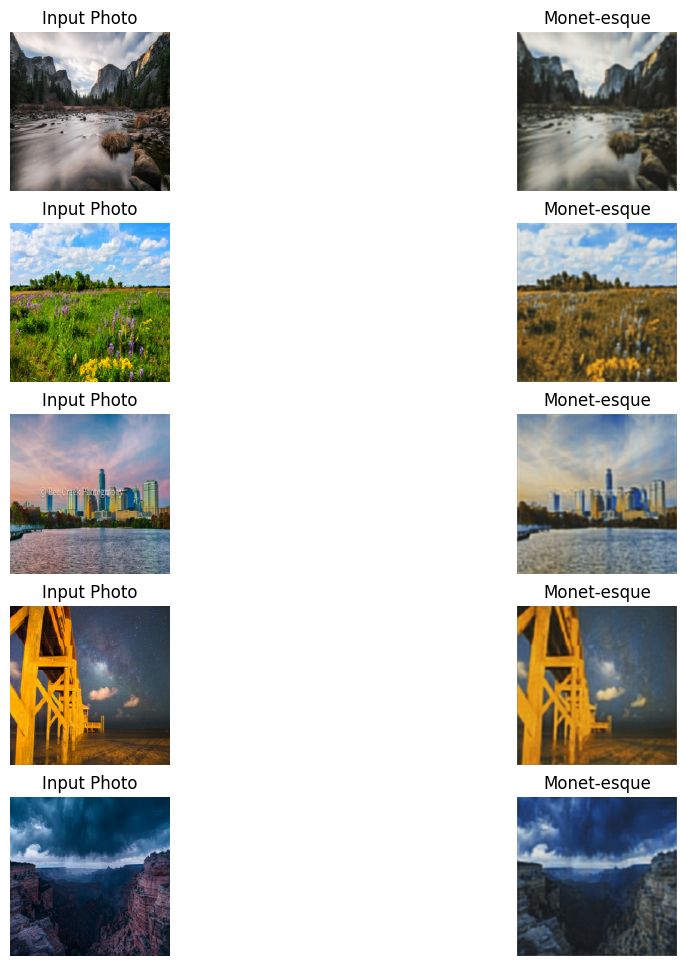

In [17]:
# Display some example images from the datasets after training the model.
_, ax = plt.subplots(5, 2, figsize=(12, 12))
for i, img in enumerate(photo_dataset.take(5)):
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Input Photo")
    ax[i, 1].set_title("Monet-esque")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
plt.show()

In [18]:
   
# Lets try and make the resnet generator[4] mentioned in the CycleGan Tutorial. [3]
# This code is based on the ResNet generator from here. [5]
# A resnet generator is 2 downsampling layers followed by 9 residual blocks, and 
# then 2 upsampling layers.
def ResnetGeneratorV2(input_shape=(256, 256, 3),
                    output_channels=3,
                    dim=64,
                    n_downsamplings=2,
                    n_blocks=9):

    def _residual_block(x):
        filters = x.shape[-1]
        h = keras.layers.Lambda(lambda z: tf.pad(z, [[0, 0], [1, 1], [1, 1], [0, 0]], mode='REFLECT'))(x)
        h = keras.layers.Conv2D(filters, 3, padding='valid', use_bias=False)(h)
        h = keras.layers.GroupNormalization(groups=-1)(h)
        h = keras.layers.Activation('relu')(h)

        h = keras.layers.Lambda(lambda z: tf.pad(z, [[0, 0], [1, 1], [1, 1], [0, 0]], mode='REFLECT'))(h)
        h = keras.layers.Conv2D(filters, 3, padding='valid', use_bias=False)(h)
        h = keras.layers.GroupNormalization(groups=-1)(h)

        return keras.layers.Add()([x, h])

    h = inputs = keras.Input(shape=input_shape)

    # Initial padding and conv
    h = keras.layers.Lambda(lambda z: tf.pad(z, [[0, 0], [3, 3], [3, 3], [0, 0]], mode='REFLECT'))(h)
    h = keras.layers.Conv2D(dim, 7, padding='valid', use_bias=False)(h)
    h = keras.layers.GroupNormalization(groups=-1)(h)
    h = keras.layers.Activation('relu')(h)

    # Downsampling
    curr_dim = dim
    for _ in range(n_downsamplings):
        curr_dim *= 2
        h = keras.layers.Conv2D(curr_dim, 3, strides=2, padding='same', use_bias=False)(h)
        h = keras.layers.GroupNormalization(groups=-1)(h)
        h = keras.layers.Activation('relu')(h)

    # Residual blocks
    for _ in range(n_blocks):
        h = _residual_block(h)

    # Upsampling
    for _ in range(n_downsamplings):
        curr_dim //= 2
        h = keras.layers.Conv2DTranspose(curr_dim, 3, strides=2, padding='same', use_bias=False)(h)
        h = keras.layers.GroupNormalization(groups=-1)(h)
        h = keras.layers.Activation('relu')(h)

    # Final padding and conv
    h = keras.layers.Lambda(lambda z: tf.pad(z, [[0, 0], [3, 3], [3, 3], [0, 0]], mode='REFLECT'))(h)
    h = keras.layers.Conv2D(output_channels, 7, padding='valid')(h)
    h = keras.layers.Activation('tanh')(h)

    return keras.Model(inputs=inputs, outputs=h)

test_gen = ResnetGeneratorV2()
print(test_gen.summary())

Model: "functional_40"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_38      │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 262, 262,  │          0 │ input_layer_38[0… │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_26 (Conv2D)  │ (None, 256, 256,  │      9,408 │ lambda[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ group_normalizatio… │ (None, 256, 256,  │        128 │ conv2d_26[0][0]   │
│ (GroupNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 256, 256,  │          0 │ group_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_27 (Conv2D)  │ (None, 128, 128,  │     73,728 │ activation[0][0]  │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ group_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_27[0][0]   │
│ (GroupNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 128, 128,  │          0 │ group_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_28 (Conv2D)  │ (None, 64, 64,    │    294,912 │ activation_1[0][… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ group_normalizatio… │ (None, 64, 64,    │        512 │ conv2d_28[0][0]   │
│ (GroupNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 64, 64,    │          0 │ group_normalizat… │
│ (Activation)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_1 (Lambda)   │ (None, 66, 66,    │          0 │ activation_2[0][… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_29 (Conv2D)  │ (None, 64, 64,    │    589,824 │ lambda_1[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ group_normalizatio… │ (None, 64, 64,    │        512 │ conv2d_29[0][0]   │
│ (GroupNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 64, 64,    │          0 │ group_normalizat… │
│ (Activation)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_2 (Lambda)   │ (None, 66, 66,    │          0 │ activation_3[0][… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_30 (Conv2D)  │ (None, 64, 64,    │    589,824 │ lambda_2[0][0]  

 Total params: 11,383,427 (43.42 MB)

 Trainable params: 11,383,427 (43.42 MB)

 Non-trainable params: 0 (0.00 B)

None


In [19]:
# Impliment the Resnet Generators and Discriminators
with strategy.scope():
    resnet_monet_generator = ResnetGeneratorV2() # transforms photos to Monet-esque paintings
    resnet_photo_generator = ResnetGeneratorV2() # transforms Monet paintings to be more like photos
    
    resnet_monet_discriminator = discriminator() # differentiates real Monet paintings and generated Monet paintings
    resnet_photo_discriminator = discriminator() # differentiates real photos and generated photos

# Create new optimizer instances for the new models
with strategy.scope():
    resnet_monet_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    resnet_photo_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    resnet_monet_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    resnet_photo_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

# Create a new CycleGAN model with the ResNet generators and discriminators
with strategy.scope():
    resnet_cycle_gan_model = CycleGan(
        resnet_monet_generator, resnet_photo_generator, resnet_monet_discriminator, resnet_photo_discriminator
    )

    resnet_cycle_gan_model.compile(
        m_gen_optimizer = resnet_monet_generator_optimizer,
        p_gen_optimizer = resnet_photo_generator_optimizer,
        m_disc_optimizer = resnet_monet_discriminator_optimizer,
        p_disc_optimizer = resnet_photo_discriminator_optimizer,
        gen_loss_fn = generator_loss,
        disc_loss_fn = discriminator_loss,
        cycle_loss_fn = calc_cycle_loss,
        identity_loss_fn = identity_loss
    )


In [20]:
# Train the ResNet CycleGAN model
EPOCHS = 2

resnet_cycle_gan_history = resnet_cycle_gan_model.fit(
    tf.data.Dataset.zip((monet_dataset, photo_dataset)),
    epochs = EPOCHS,
    steps_per_epoch=300
)

Epoch 1/2
300/300 ━━━━━━━━━━━━━━━━━━━━ 221s 267ms/step - monet_disc_loss: 0.6832 - monet_gen_loss: 8.4348 - photo_disc_loss: 0.6899 - photo_gen_loss: 8.5067
Epoch 2/2
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 112us/step - monet_disc_loss: 0.6529 - monet_gen_loss: 7.3277 - photo_disc_loss: 0.6897 - photo_gen_loss: 7.5431


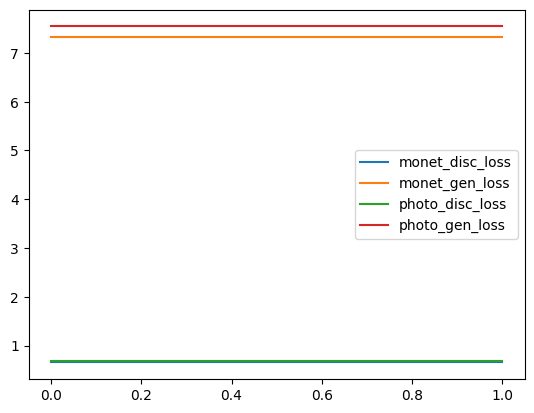

In [21]:
# Plot the training losses per epoch
history_keys = resnet_cycle_gan_history.history.keys()

for key in history_keys:
    cghk = resnet_cycle_gan_history.history[key]
    plt.plot(cghk, label=key)
plt.legend()
plt.show()

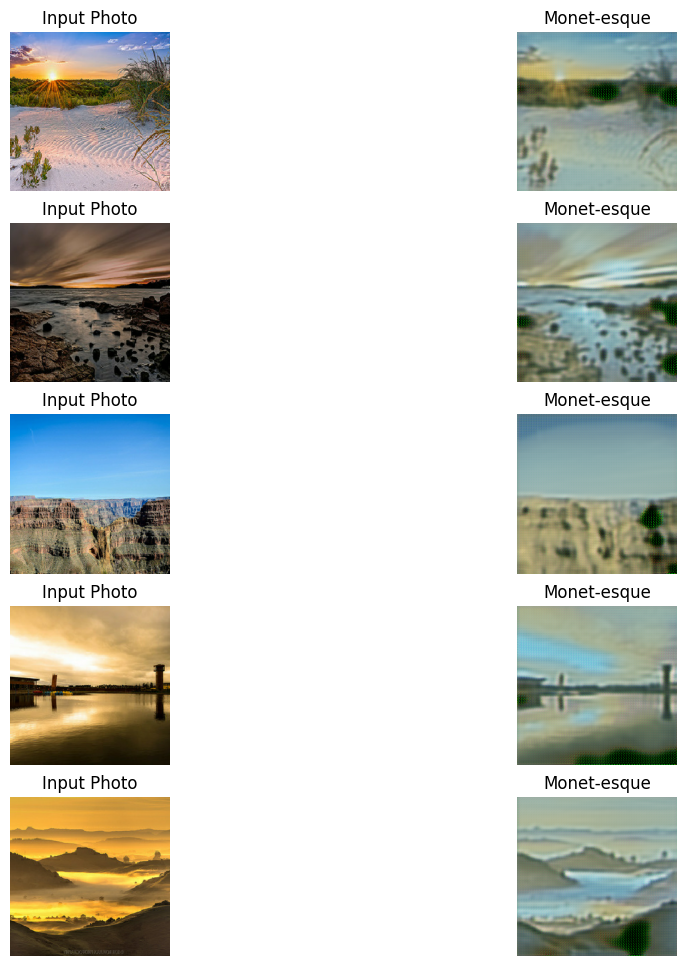

In [22]:
# Display some example images from the datasets after training the model.
_, ax = plt.subplots(5, 2, figsize=(12, 12))
for i, img in enumerate(photo_dataset.take(5)):
    prediction = resnet_monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Input Photo")
    ax[i, 1].set_title("Monet-esque")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
plt.show()

In [23]:
# Impliment the Resnet Generators and Discriminators
resnet_monet_generator_2 = ResnetGeneratorV2() # transforms photos to Monet-esque paintings
resnet_photo_generator_2 = ResnetGeneratorV2() # transforms Monet paintings to be more like photos

resnet_monet_discriminator_2 = discriminator() # differentiates real Monet paintings and generated Monet paintings
resnet_photo_discriminator_2 = discriminator() # differentiates real photos and generated photos

# Create new optimizer instances for the new models
resnet_monet_generator_optimizer_2 = tf.keras.optimizers.Adam(0.005, beta_1=0.5)
resnet_photo_generator_optimizer_2 = tf.keras.optimizers.Adam(0.005, beta_1=0.5)
resnet_monet_discriminator_optimizer_2 = tf.keras.optimizers.Adam(0.005, beta_1=0.5)
resnet_photo_discriminator_optimizer_2 = tf.keras.optimizers.Adam(0.005, beta_1=0.5)

# Create a new CycleGAN model with the ResNet generators and discriminators
resnet_cycle_gan_model_2 = CycleGan(
    resnet_monet_generator_2, resnet_photo_generator_2, resnet_monet_discriminator_2, resnet_photo_discriminator_2
)

resnet_cycle_gan_model_2.compile(
    m_gen_optimizer = resnet_monet_generator_optimizer_2,
    p_gen_optimizer = resnet_photo_generator_optimizer_2,
    m_disc_optimizer = resnet_monet_discriminator_optimizer_2,
    p_disc_optimizer = resnet_photo_discriminator_optimizer_2,
    gen_loss_fn = generator_loss,
    disc_loss_fn = discriminator_loss,
    cycle_loss_fn = calc_cycle_loss,
    identity_loss_fn = identity_loss
)
# Train the ResNet CycleGAN model
EPOCHS = 20

resnet_cycle_gan_history_2 = resnet_cycle_gan_model_2.fit(
    tf.data.Dataset.zip((monet_dataset, photo_dataset)),
    epochs = EPOCHS,
    steps_per_epoch=300
)

Epoch 1/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 221s 267ms/step - monet_disc_loss: 0.6800 - monet_gen_loss: 10.3171 - photo_disc_loss: 0.6475 - photo_gen_loss: 10.5410
Epoch 2/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 112us/step - monet_disc_loss: 0.6965 - monet_gen_loss: 11.2414 - photo_disc_loss: 0.5836 - photo_gen_loss: 13.8908
Epoch 3/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 82s 267ms/step - monet_disc_loss: 0.6508 - monet_gen_loss: 9.7662 - photo_disc_loss: 0.4700 - photo_gen_loss: 11.1198
Epoch 4/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 52us/step - monet_disc_loss: 0.6296 - monet_gen_loss: 12.7157 - photo_disc_loss: 0.7144 - photo_gen_loss: 13.7859
Epoch 5/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 82s 267ms/step - monet_disc_loss: 0.5992 - monet_gen_loss: 10.2419 - photo_disc_loss: 0.6040 - photo_gen_loss: 10.3748
Epoch 6/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 52us/step - monet_disc_loss: 0.4908 - monet_gen_loss: 8.2976 - photo_disc_loss: 0.8202 - photo_gen_loss: 8.2239
Epoch 7/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 82s 267ms/ste

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


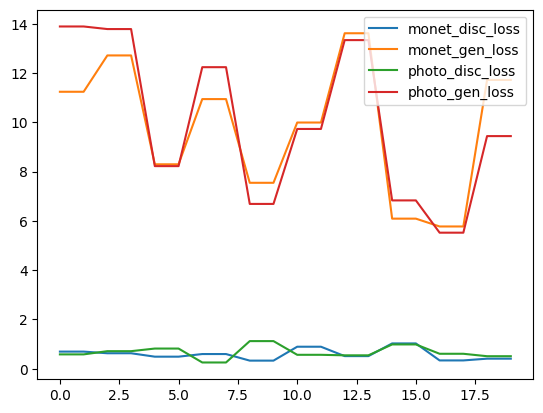

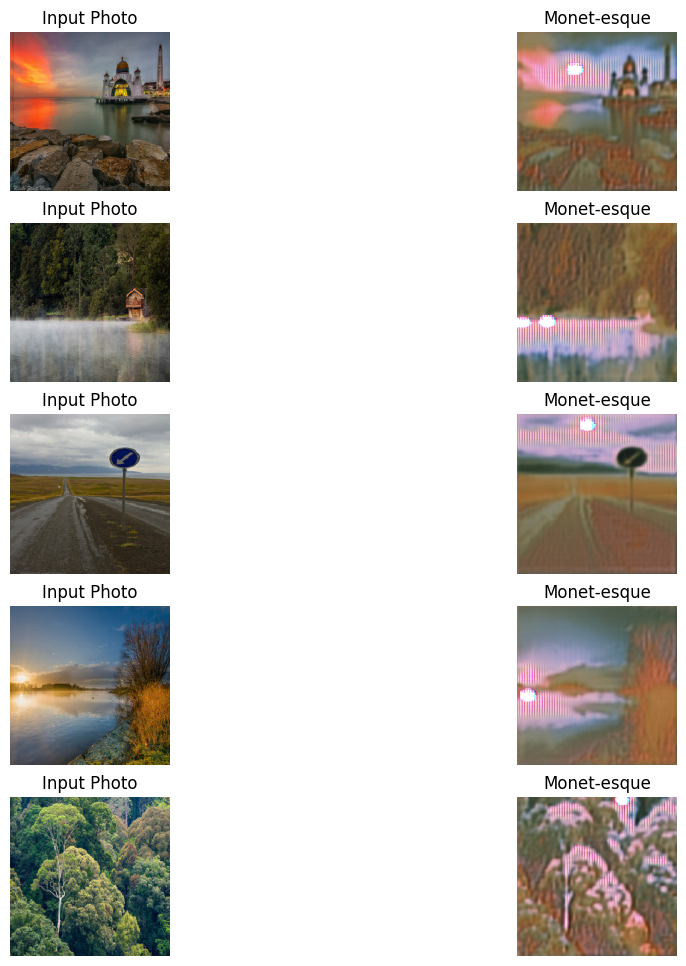

In [24]:
# Plot the training losses per epoch
history_keys = resnet_cycle_gan_history_2.history.keys()

for key in history_keys:
    cghk = resnet_cycle_gan_history_2.history[key]
    plt.plot(cghk, label=key)
plt.legend()
plt.show()

# Display some example images from the datasets after training the model.
_, ax = plt.subplots(5, 2, figsize=(12, 12))
for i, img in enumerate(photo_dataset.take(5)):
    prediction = resnet_monet_generator_2(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Input Photo")
    ax[i, 1].set_title("Monet-esque")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
plt.show()

In [29]:
import PIL
! mkdir ../images

mkdir: cannot create directory ‘../images’: File exists


In [31]:
!cp -a images/. ../images

In [26]:
i = 1
for img in photo_dataset:
    prediction = resnet_monet_generator_2(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    im = PIL.Image.fromarray(prediction)
    im.save("../images/" + str(i) + ".jpg")
    i += 1




In [32]:
import shutil
shutil.make_archive("/kaggle/working/images", 'zip', "/kaggle/images")

'/kaggle/working/images.zip'

## Results and Analysis
3 different models were tried in this notebooks.  A unet model with 2 epoch, a resnet model with 2 epoch, and finally a unet model with a higher learning rate of 0.005 and 20 epochs.  

The thinking with the 3rd model is that due to long training time I really haven't been reaching a model that stablizes. However, if I increase the learning rate and epochs for this should speed up the process. However, looking at the results, it doesn't look good, there seems to be some sort of distortion creating pink lines in the images.  The other 2 models images look less like monets but dont have that distortion. 

Also I tested both a GPU and TPU for run times and using a GPU is definately faster.  My guess is this is due to having a batch size of 1.  I could not get other batch sizes to work with the TPU or GPU on kaggle.

## Conclusion

One of the big challenges with this and any deep learning is the training time.  One of the big downsides of this Kaggle competition is I'm unable to upload a dataset created on my personal computer, which has a faster GPU than the one attached to this notebook.  The next steps for this analysis would be to continue to tune the hyper parameters.  Implimenting some sort of dynamic learning rate would be useful.  Also, trying out some other generator and disciminator architectures would be interesting, I'm curious if there are better designs to reduce runtime while maintaining performance.

## References
[1] https://www.kaggle.com/competitions/gan-getting-started/overview

[2] https://www.kaggle.com/code/amyjang/monet-cyclegan-tutorial

[3] https://www.tensorflow.org/tutorials/generative/cyclegan

[4] https://arxiv.org/abs/1703.10593

[5] https://github.com/LynnHo/CycleGAN-Tensorflow-2